In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from sklearn.metrics import classification_report
import PIL
from PIL import Image
import glob
import os
import cv2
import torch
from torch.utils.data import DataLoader, Dataset
import mtcnn
from mtcnn.mtcnn import MTCNN

In [2]:
print('Pillow Version:', PIL.__version__)

Pillow Version: 7.0.0


In [3]:
os.getcwd()

'C:\\Users\\Pooja.Radhakrishnan\\Desktop\\Capstone'

In [4]:
df = pd.read_csv('train.csv')
df

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask
...,...,...,...,...,...,...
15407,1894.jpg,437,121,907,644,face_with_mask
15408,1894.jpg,557,363,876,636,mask_surgical
15409,1894.jpg,411,3,940,325,hat
15410,3216.png,126,69,409,463,face_with_mask


# Exploratory Data Analysis

In [5]:
"""image = Image.open('images/6098.jpg')
print(image.format)
print(image.mode)
print(image.size)
image.show()
"""

"image = Image.open('images/6098.jpg')\nprint(image.format)\nprint(image.mode)\nprint(image.size)\nimage.show()\n"

In [6]:
print("Information of the dataset:\n", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15412 entries, 0 to 15411
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       15412 non-null  object
 1   x1         15412 non-null  int64 
 2   x2         15412 non-null  int64 
 3   y1         15412 non-null  int64 
 4   y2         15412 non-null  int64 
 5   classname  15412 non-null  object
dtypes: int64(4), object(2)
memory usage: 722.6+ KB
Information of the dataset:
 None


In [7]:
print("Statistical description of the dataset:\n", df.describe())

Statistical description of the dataset:
                  x1            x2            y1            y2
count  15412.000000  15412.000000  15412.000000  15412.000000
mean     343.696016    155.338373    531.480535    346.346224
std      312.239316    170.595556    398.407997    287.384566
min        0.000000      0.000000     13.000000     13.000000
25%      155.000000     52.000000    336.000000    194.000000
50%      279.000000    126.000000    462.000000    285.000000
75%      439.000000    211.000000    613.000000    419.000000
max     3598.000000   3549.000000   4912.000000   4370.000000


In [8]:
print(" Analysis of Null values in the dataset:\n", df.isnull().sum())

 Analysis of Null values in the dataset:
 name         0
x1           0
x2           0
y1           0
y2           0
classname    0
dtype: int64


In [9]:
print("The number of unique images are: ", len(df['name'].unique()))

The number of unique images are:  4326


In [10]:
print("Total number of images:", len(df))

Total number of images: 15412


In [11]:
#Output varaible - 'classname'
print("The uniquely classified classes are:", df['classname'].unique())
print("\nThe number of unique classes are:", len(df['classname'].unique()))

The uniquely classified classes are: ['face_with_mask' 'mask_colorful' 'face_no_mask'
 'face_with_mask_incorrect' 'mask_surgical' 'face_other_covering'
 'scarf_bandana' 'eyeglasses' 'helmet' 'face_shield' 'sunglasses' 'hood'
 'hat' 'goggles' 'hair_net' 'hijab_niqab' 'other' 'gas_mask'
 'balaclava_ski_mask' 'turban']

The number of unique classes are: 20


In [12]:
print("The Value Counts of all the categories are:", df['classname'].value_counts())

The Value Counts of all the categories are: face_with_mask              4180
mask_surgical               2430
mask_colorful               1876
face_no_mask                1569
face_other_covering         1372
eyeglasses                   914
hat                          823
sunglasses                   358
hair_net                     287
scarf_bandana                260
goggles                      192
helmet                       187
hijab_niqab                  173
face_shield                  160
hood                         159
face_with_mask_incorrect     150
balaclava_ski_mask           134
turban                        94
gas_mask                      55
other                         39
Name: classname, dtype: int64


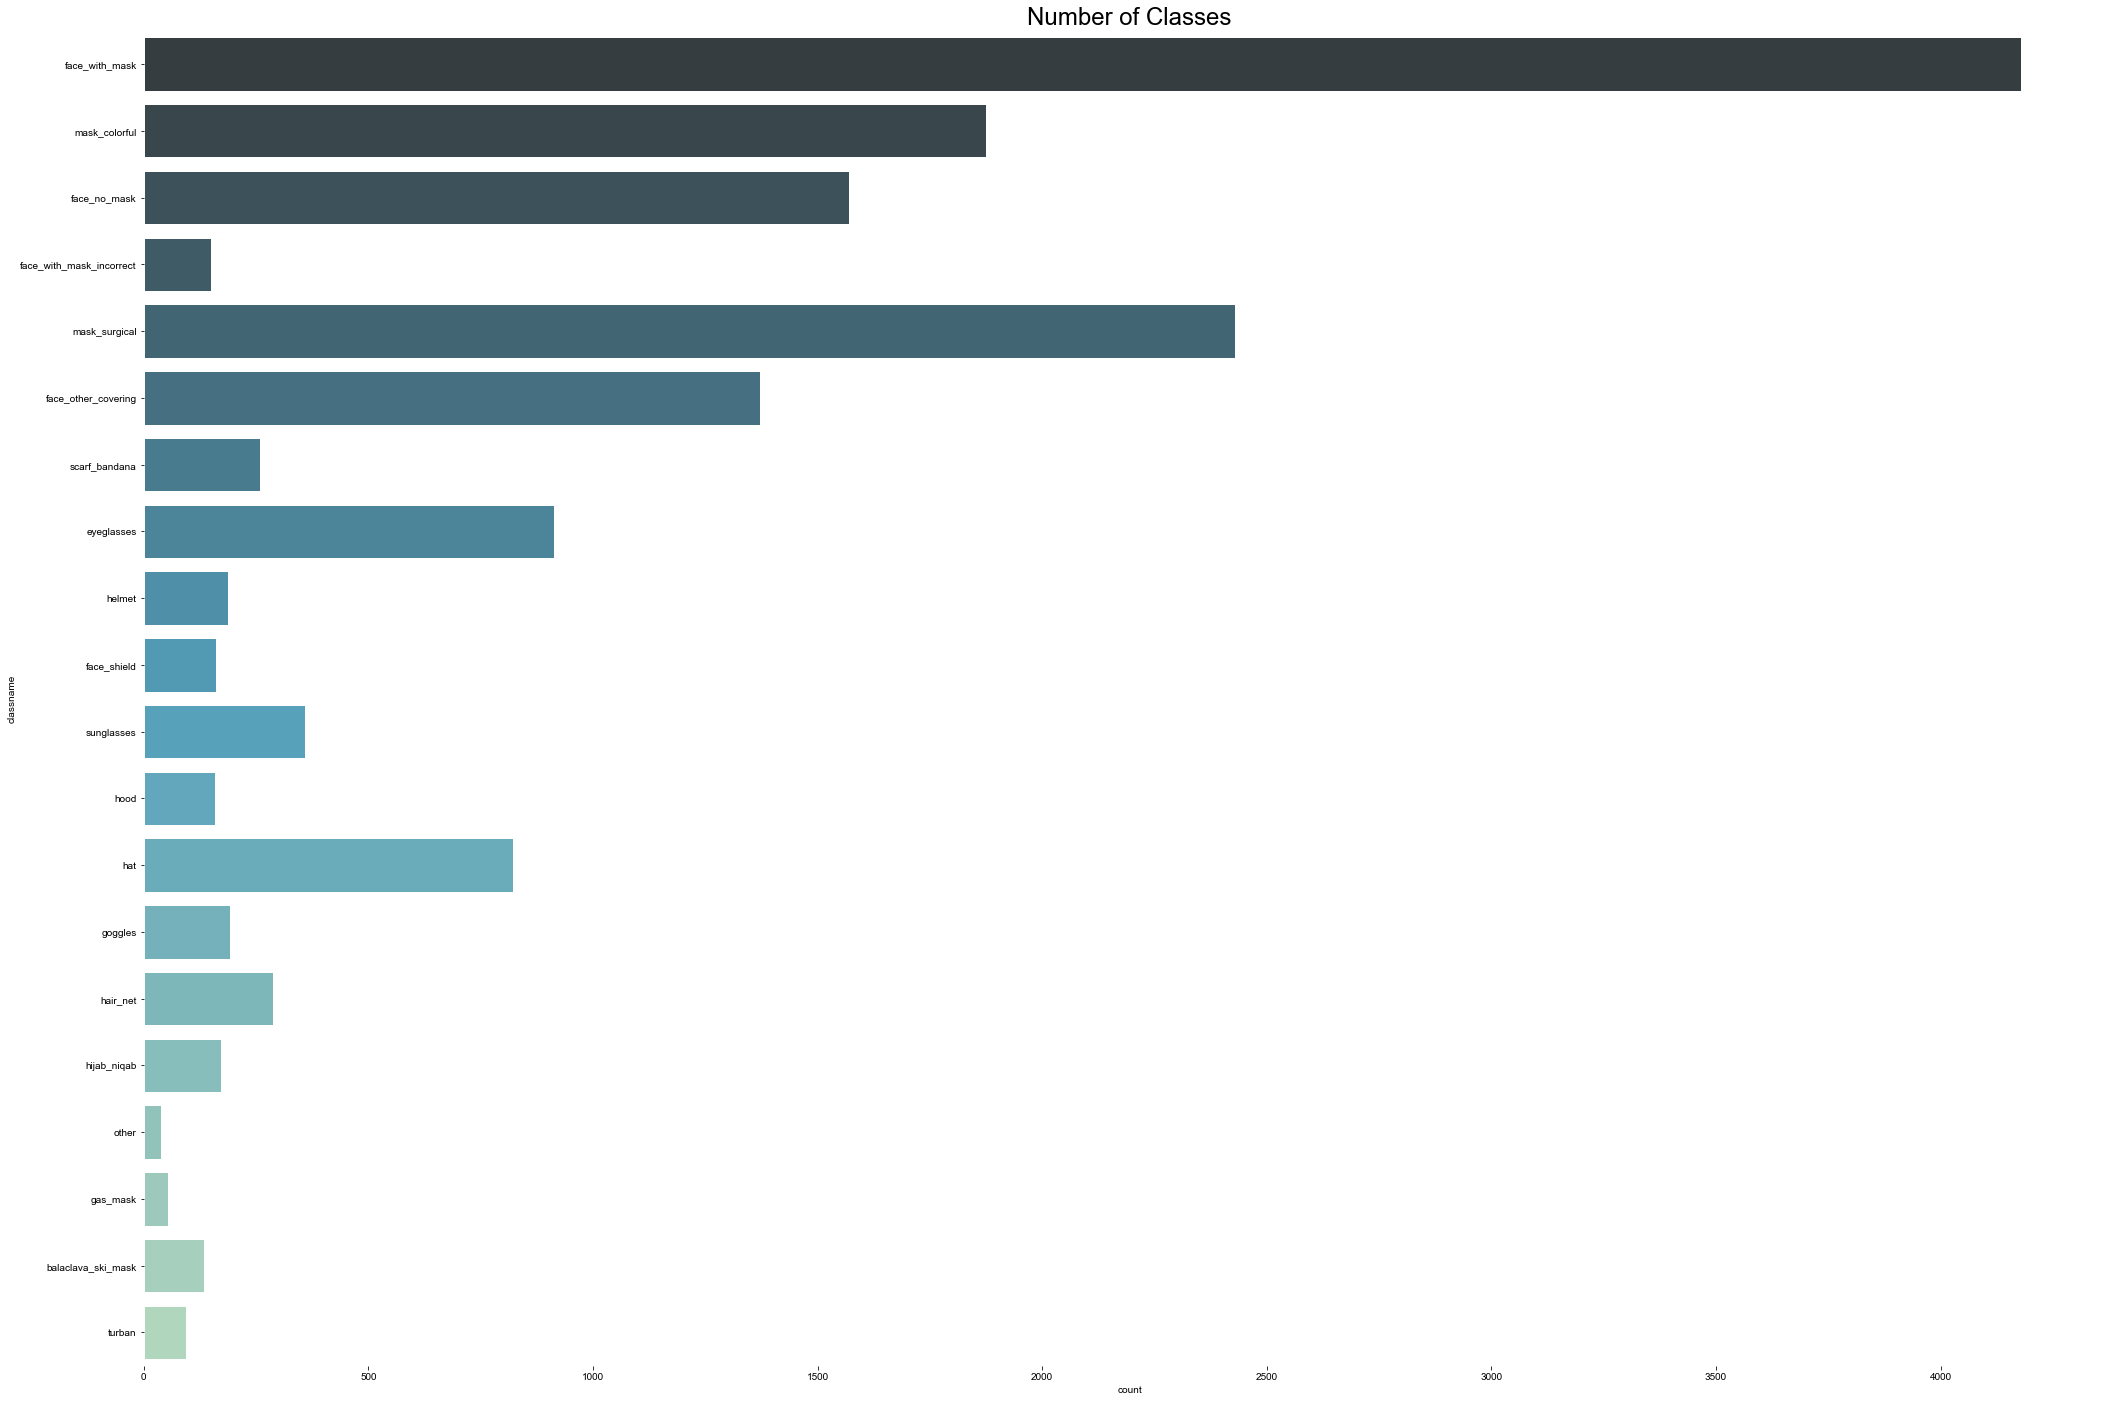

In [13]:
f = plt.subplots(figsize = (30,20))
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
sns.countplot(y = df['classname'], data = df, label = 'Total', palette = 'GnBu_d').set_title('Number of Classes')
sns.despine(left=True, bottom=True)
plt.tight_layout()

In [14]:
#The dataframe contains redundant data with other features of the image as well, so let's narrow it down to just masks
with_mask = df[df['classname'] == 'face_with_mask']
without_mask = df[df['classname'] == 'face_no_mask']
print("Number of images with face mask:", len(with_mask))
print("Number of images without face mask:", len(without_mask))
df2 = with_mask
df2 = df2.append(without_mask)
df2

Number of images with face mask: 4180
Number of images without face mask: 1569


,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
7,4591.png,239,9,522,342,face_with_mask
16,4287.png,80,0,629,599,face_with_mask
17,4893.png,179,8,664,599,face_with_mask
...,...,...,...,...,...,...
15337,2376.png,227,2,438,173,face_no_mask
15347,6221.jpg,635,183,741,313,face_no_mask
15356,6096.jpg,264,53,489,324,face_no_mask
15394,6326.jpg,850,271,1642,1393,face_no_mask


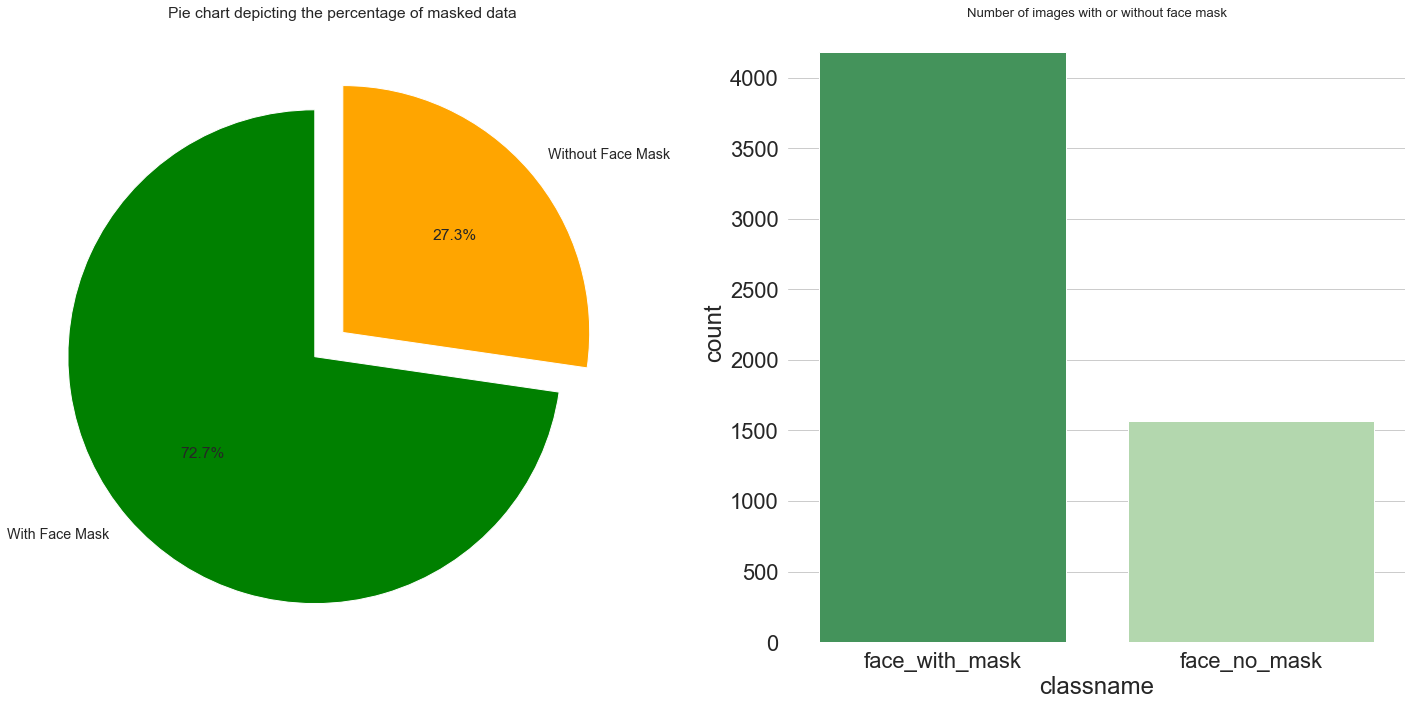

In [15]:
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))
sns.set(style="whitegrid", color_codes=True, font_scale = 1.3)
explode = (0.15, 0)
colors = ['green', 'orange']
ax[0].pie([len(with_mask), len(without_mask)], labels = ('With Face Mask', 'Without Face Mask'), explode = explode, colors = colors, startangle=90, autopct='%1.1f%%')
ax[0].set_title('Pie chart depicting the percentage of masked data')
ax[1] = sns.set(style="whitegrid", color_codes=True, font_scale = 1.1)
sns.countplot(x = 'classname', data = df2, label = 'Total', palette = 'Greens_r').set_title('Number of images with or without face mask')
sns.despine(left=True, bottom=True)
plt.tight_layout()

In [16]:
pictures = os.path.join("images")
annotations = os.path.join("annotations")

In [17]:
#Actually it is 6024, but there's an extra .git file in the folder
image = os.listdir(pictures)
print(type(image))
i = len(os.listdir(pictures))
print("Number of images: ", i)
image[0]

<class 'list'>
Number of images:  6024


'0001.jpg'

In [18]:
annot = os.listdir(annotations)
a = len(os.listdir(annotations))
print("Number of annotations: ", a)

Number of annotations:  4326


In [19]:
annot.sort()
annot[0]

'1801.jpg.json'

In [20]:
#Actually it is 1698, but I have a .git file in the folder and hence it's 1699
print("Difference: ", i-a)

Difference:  1698


In [21]:
image.sort()
image[82]

'0092.png'

In [22]:
#The annotations are the files beginning with 1801.jpg.json, and hence the training set also should begin from there
image.sort()
test = image[:1698]
_train = image[1698:]

#test[2]
#del test[0]
#del test[0]
test[0]

'0001.jpg'

In [23]:
_train[0]

'1801.jpg'

In [24]:
0.8 * len(_train)

3460.8

In [25]:
#Splitting the data into train(80%) and validation(20%) sets
train = _train[:3460]
validation = _train[3460:]
print("Training set size:", len(train))
print("Validation set size:", len(validation))
print("Test set size:", len(test))

Training set size: 3460
Validation set size: 866
Test set size: 1698


In [26]:
validation[0]

'5441.jpg'

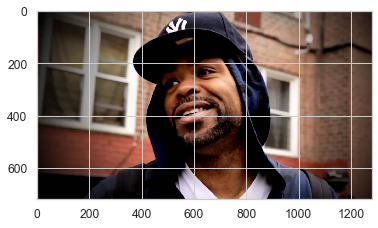

In [27]:
img = plt.imread(os.path.join(pictures,test[0]))
plt.imshow(img)
plt.show()

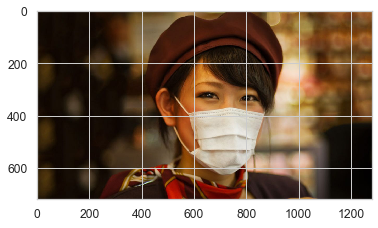

'1894.jpg'

In [28]:
img = plt.imread(os.path.join(pictures,train[85]))
plt.imshow(img)
plt.show()
train[85]

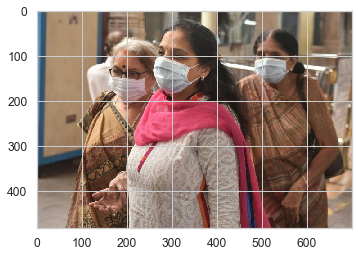

'1895.jpg'

In [29]:
img = plt.imread(os.path.join(pictures,train[86]))
plt.imshow(img)
plt.show()
train[86]

6098.jpg
4    face_no_mask
Name: classname, dtype: object
<class 'int'>


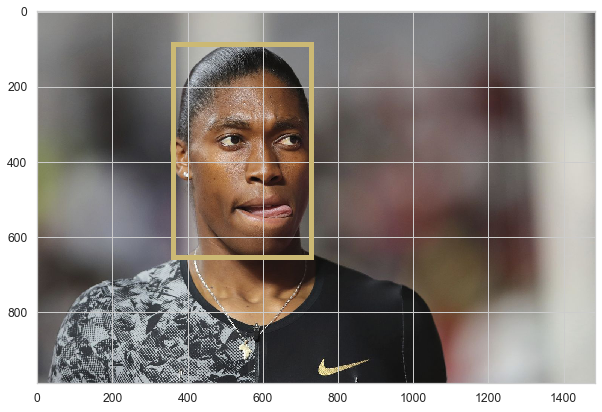

2296.png
2019    face_with_mask
Name: classname, dtype: object
<class 'int'>


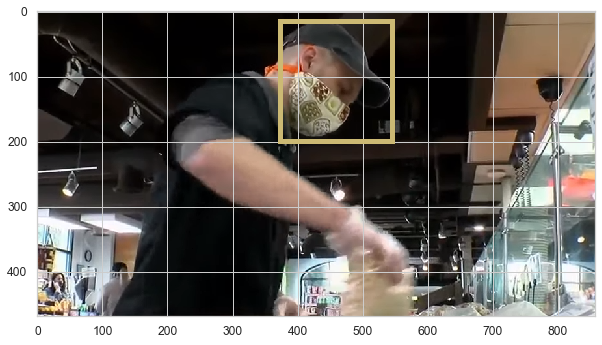

In [30]:
#Fitting the coordinates

def image_details(index):
    image_name = df2['name'][index]
    print(image_name)
    image_class = df2[df2['name'] == image_name]['classname']
    print(image_class)
    x1 = int(df2[df2['name'] == image_name]['x1'][index])
    x2 = int(df2[df2['name'] == image_name]['x2'][index])
    y1 = int(df2[df2['name'] == image_name]['y1'][index])
    y2 = int(df2[df2['name'] == image_name]['y2'][index])
    img = plt.imread(os.path.join(pictures, image_name))
    return x1, x2, y1, y2, img, image_class
    

def coords_box(index):
    x1, x2, y1, y2, img, image_class = image_details(index)
    print(type(x1))
    fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,10))
    ax.imshow(img)
    rect = patches.Rectangle((x1,x2),y1-x1,y2-x2,linewidth=5,edgecolor='y',facecolor='none')
    ax.add_patch(rect)
    plt.show()

coords_box(4)
coords_box(2019)

In [31]:
df2.sort_values('name',axis=0,inplace=True)
df2

,name,x1,x2,y1,y2,classname
13381,1801.jpg,451,186,895,697,face_no_mask
3463,1802.jpg,110,71,273,272,face_with_mask
14835,1803.jpg,126,75,303,333,face_with_mask
5867,1804.jpg,112,113,262,307,face_with_mask
6194,1805.jpg,728,180,853,336,face_with_mask
...,...,...,...,...,...,...
13547,6433.png,146,107,304,313,face_with_mask
13549,6433.png,669,105,798,281,face_with_mask
13550,6433.png,765,142,976,364,face_with_mask
13548,6433.png,536,152,665,333,face_with_mask


In [32]:
train_df = df2[df2['name'].isin(train)]
train_df

,name,x1,x2,y1,y2,classname
13381,1801.jpg,451,186,895,697,face_no_mask
3463,1802.jpg,110,71,273,272,face_with_mask
14835,1803.jpg,126,75,303,333,face_with_mask
5867,1804.jpg,112,113,262,307,face_with_mask
6194,1805.jpg,728,180,853,336,face_with_mask
...,...,...,...,...,...,...
8451,5429.jpg,151,59,612,719,face_with_mask
9172,5433.jpg,330,118,483,324,face_with_mask
12326,5435.jpg,180,127,553,693,face_with_mask
14705,5436.jpg,253,365,459,648,face_with_mask


In [33]:
validation_df = df2[df2['name'].isin(validation)]
validation_df

,name,x1,x2,y1,y2,classname
4687,5441.jpg,359,115,639,509,face_with_mask
14796,5442.jpg,420,69,664,376,face_with_mask
9761,5445.jpg,416,82,467,217,face_with_mask
12582,5447.jpg,114,7,602,678,face_no_mask
5579,5452.jpg,732,90,1269,842,face_with_mask
...,...,...,...,...,...,...
13547,6433.png,146,107,304,313,face_with_mask
13549,6433.png,669,105,798,281,face_with_mask
13550,6433.png,765,142,976,364,face_with_mask
13548,6433.png,536,152,665,333,face_with_mask


In [34]:
"""data = []
path = 'images/'
def grey_image():
       for i in range(len(df2)):
            arr = []
            for j in df2.iloc[i]:
                   arr.append(j)
            img_array = cv2.imread(os.path.join(pictures,arr[0]), cv2.IMREAD_GRAYSCALE)
            data.append([img_array,arr[5]])
grey_image()
"""

"data = []\npath = 'images/'\ndef grey_image():\n       for i in range(len(df2)):\n            arr = []\n            for j in df2.iloc[i]:\n                   arr.append(j)\n            img_array = cv2.imread(os.path.join(pictures,arr[0]), cv2.IMREAD_GRAYSCALE)\n            data.append([img_array,arr[5]])\ngrey_image()\n"

In [35]:
"""
size = 50
features = []
labels = []
path = 'images/'
def grey_image_face():
       for i in range(len(df2)):
            arr = []
            for j in df2.iloc[i]:
                arr.append(j)
            imgs = cv2.imread(os.path.join(pictures,arr[0]), cv2.IMREAD_GRAYSCALE)
            #Using x1,x2,y1,y2
            cropped = imgs[arr[2]:arr[4], arr[1]:arr[3]]
            try:
                faces = cv2.resize(cropped,(size,size))
            except:
                continue
            features.append(faces)
            labels.append(arr[5])
grey_image_face()   
"""

"\nsize = 50\nfeatures = []\nlabels = []\npath = 'images/'\ndef grey_image_face():\n       for i in range(len(df2)):\n            arr = []\n            for j in df2.iloc[i]:\n                arr.append(j)\n            imgs = cv2.imread(os.path.join(pictures,arr[0]), cv2.IMREAD_GRAYSCALE)\n            #Using x1,x2,y1,y2\n            cropped = imgs[arr[2]:arr[4], arr[1]:arr[3]]\n            try:\n                faces = cv2.resize(cropped,(size,size))\n            except:\n                continue\n            features.append(faces)\n            labels.append(arr[5])\ngrey_image_face()   \n"

In [36]:
size = 50
train_data = []
path = 'images/'
def train_data_image_processing():
       for i in range(len(df2)):
            arr = []
            for j in df2.iloc[i]:
                arr.append(j)
            img = cv2.imread(os.path.join(pictures,arr[0]),cv2.IMREAD_GRAYSCALE)
            cropped = img[arr[2]:arr[4],arr[1]:arr[3]]
            cropped_img = cv2.resize(cropped,(size,size))
            train_data.append([cropped_img,arr[5]])
            
            
train_data_image_processing()      

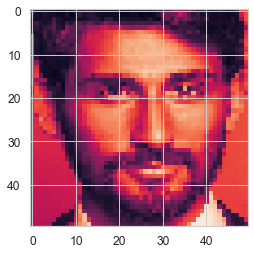

In [37]:
plt.imshow(train_data[0][0])

In [38]:
x = []
y = []

for images, labels in train_data:
    x.append(images)
    y.append(labels)

In [39]:
"""print(x.shape)
print(y.shape)
print(x[4].shape)
"""

'print(x.shape)\nprint(y.shape)\nprint(x[4].shape)\n'

In [40]:
lbl = LabelEncoder()
y = lbl.fit_transform(y)

In [41]:
x = np.array(x).reshape(-1,50,50,1)
x = tf.keras.utils.normalize(x,axis=1)

In [42]:
#One hot encoding
y = to_categorical(y)

In [43]:
print(x.shape)
print(y.shape)
print(x[4].shape)


(5749, 50, 50, 1)
(5749, 2)
(50, 50, 1)


In [44]:
y[20]

array([1., 0.], dtype=float32)

In [45]:
size = 50
val_data = []
path ='images/'
def val_data_image_processing():
       for i in range(len(validation_df)):
            arr = []
            for j in validation_df.iloc[i]:
                arr.append(j)
            img = cv2.imread(os.path.join(pictures,arr[0]),cv2.IMREAD_GRAYSCALE)
            cropped = img[arr[2]:arr[4],arr[1]:arr[3]]
            cropped_image=cv2.resize(cropped,(size,size))
            val_data.append([cropped_image,arr[5]])
val_data_image_processing()      

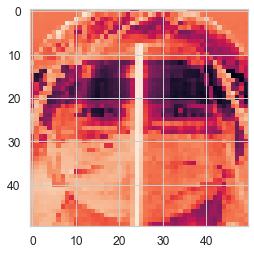

In [46]:
plt.imshow(val_data[0][0])

In [47]:
x1 = []
y1 = []

for images, labels in val_data:
    x1.append(images)
    y1.append(labels)


In [48]:
lbl1 = LabelEncoder()
y1 = lbl1.fit_transform(y1)

In [49]:
x1 = np.array(x1).reshape(-1,50,50,1)
x1 = tf.keras.utils.normalize(x1,axis=1)

In [50]:
y1 = to_categorical(y1)

In [51]:
model=Sequential()
model.add(Conv2D(100,(3,3),input_shape = x.shape[1:], activation='relu', strides=2))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [52]:
opt = tf.keras.optimizers.Adam(lr = 1e-3, decay = 1e-5)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy']) 
history = model.fit(x,y, epochs=30, batch_size=5, validation_data = (x1,y1))
(eval_loss, eval_accuracy) = model.evaluate(x1, y1, batch_size=5,verbose=1)
print('\n\n Accuracy: {:.2f}%'.format(eval_accuracy * 100)) 
print('Loss: {}'.format(eval_loss)) 

Epoch 1/30
1150/1150 [==============================] - 12s 10ms/step - loss: 0.5630 - accuracy: 0.7295 - val_loss: 1.0474 - val_accuracy: 0.2913
Epoch 2/30
1150/1150 [==============================] - 11s 10ms/step - loss: 0.4826 - accuracy: 0.7636 - val_loss: 0.8068 - val_accuracy: 0.6073
Epoch 3/30
1150/1150 [==============================] - 11s 10ms/step - loss: 0.4237 - accuracy: 0.8085 - val_loss: 0.6564 - val_accuracy: 0.7041
Epoch 4/30
1150/1150 [==============================] - 12s 10ms/step - loss: 0.3882 - accuracy: 0.8281 - val_loss: 0.6455 - val_accuracy: 0.7151
Epoch 5/30
1150/1150 [==============================] - 12s 10ms/step - loss: 0.3523 - accuracy: 0.8433 - val_loss: 0.4867 - val_accuracy: 0.8265
Epoch 6/30
1150/1150 [==============================] - 12s 10ms/step - loss: 0.3230 - accuracy: 0.8595 - val_loss: 0.4183 - val_accuracy: 0.8502
Epoch 7/30
1150/1150 [==============================] - 11s 10ms/step - loss: 0.3094 - accuracy: 0.8701 - val_loss: 0.5108 -

In [53]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


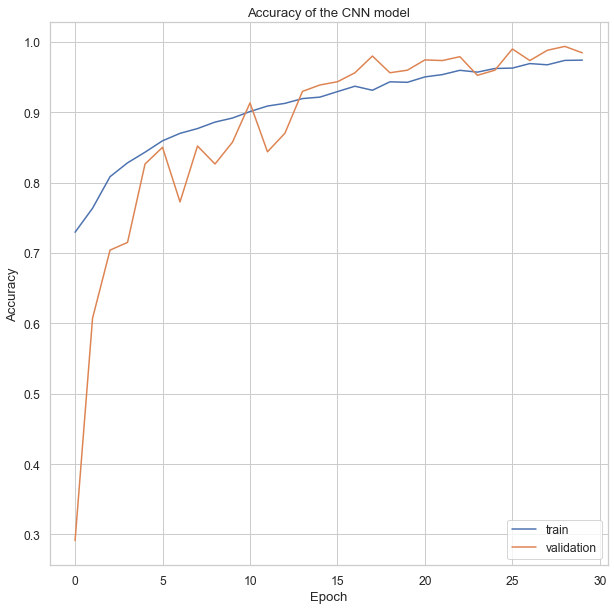

In [54]:
fig = plt.figure(figsize = (10,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy of the CNN model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

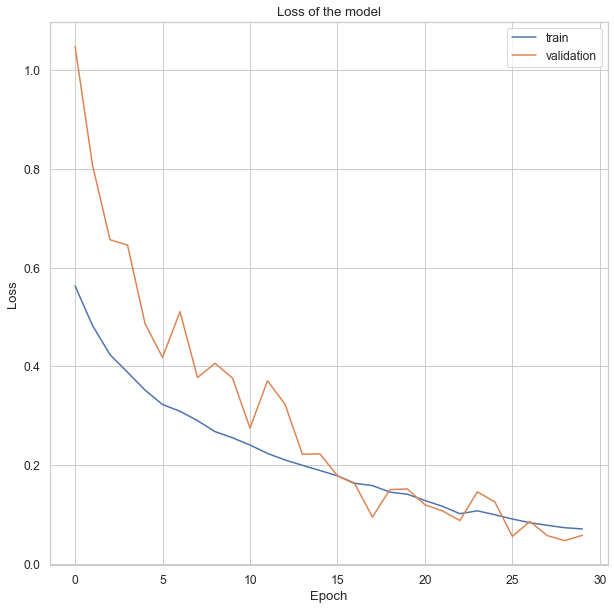

In [55]:
fig = plt.figure(figsize = (10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of the model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [56]:
print(model.predict(x1, batch_size = 5))

[[8.4607804e-05 9.9991536e-01]
 [2.8264222e-10 1.0000000e+00]
 [2.1570595e-06 9.9999785e-01]
 ...
 [4.0162901e-10 1.0000000e+00]
 [2.2822351e-07 9.9999976e-01]
 [1.2511977e-09 1.0000000e+00]]


In [57]:
pred = model.predict(x1, batch_size = 5)
pred = np.argmax(pred, axis=1)
print(classification_report(y1.argmax(axis = 1), pred, target_names = lbl.classes_))

                precision    recall  f1-score   support

  face_no_mask       1.00      0.99      0.99      1009
face_with_mask       0.85      0.98      0.91        86

      accuracy                           0.98      1095
     macro avg       0.92      0.98      0.95      1095
  weighted avg       0.99      0.98      0.98      1095



In [58]:
from sklearn.metrics import confusion_matrix as cm
cm(y1.argmax(axis=1), pred)

array([[994,  15],
       [  2,  84]], dtype=int64)

In [59]:
len(y1.argmax(axis=1))

1095

In [60]:
detector = MTCNN()
test_df = []


for image in test:
    img = plt.imread(os.path.join(pictures,image))
    faces = detector.detect_faces(img)
    _test = []
    
    for face in faces:
        face_frame = face['box']
        _test.append([image, face_frame])
    test_df.append(_test)   

In [61]:
_test = []
for i in test_df:
    if len(i) > 0:
        if len(i) == 1:
            _test.append(i[0])
        else:
            for j in i:
                _test.append(j)  

In [62]:
_test

[['0001.jpg', [441, 108, 341, 416]],
 ['0003.jpg', [1292, 218, 865, 1088]],
 ['0004.jpg', [630, 176, 212, 266]],
 ['0006.jpg', [441, 668, 57, 70]],
 ['0007.jpg', [922, 565, 102, 121]],
 ['0007.jpg', [1696, 171, 133, 145]],
 ['0007.jpg', [1368, 391, 88, 89]],
 ['0007.jpg', [231, 228, 145, 165]],
 ['0009.jpg', [613, 412, 126, 134]],
 ['0010.jpg', [770, 292, 143, 173]],
 ['0010.jpg', [558, 308, 114, 141]],
 ['0011.jpg', [204, 72, 65, 85]],
 ['0011.jpg', [406, 106, 70, 97]],
 ['0012.jpg', [1089, 433, 58, 80]],
 ['0012.jpg', [144, 326, 63, 77]],
 ['0012.jpg', [896, 389, 60, 75]],
 ['0012.jpg', [779, 360, 66, 76]],
 ['0012.jpg', [85, 381, 43, 52]],
 ['0014.jpg', [750, 192, 26, 30]],
 ['0014.jpg', [578, 124, 24, 24]],
 ['0015.jpg', [295, 343, 108, 135]],
 ['0017.jpg', [476, 51, 56, 71]],
 ['0018.jpg', [334, 43, 127, 173]],
 ['0020.jpg', [1138, 82, 303, 405]],
 ['0021.jpg', [162, 79, 31, 33]],
 ['0021.jpg', [102, 312, 16, 22]],
 ['0022.jpg', [752, 190, 90, 91]],
 ['0022.jpg', [360, 205, 18, 23

In [63]:
test_df

[[['0001.jpg', [441, 108, 341, 416]]],
 [],
 [['0003.jpg', [1292, 218, 865, 1088]]],
 [['0004.jpg', [630, 176, 212, 266]]],
 [],
 [['0006.jpg', [441, 668, 57, 70]]],
 [['0007.jpg', [922, 565, 102, 121]],
  ['0007.jpg', [1696, 171, 133, 145]],
  ['0007.jpg', [1368, 391, 88, 89]],
  ['0007.jpg', [231, 228, 145, 165]]],
 [['0009.jpg', [613, 412, 126, 134]]],
 [['0010.jpg', [770, 292, 143, 173]], ['0010.jpg', [558, 308, 114, 141]]],
 [['0011.jpg', [204, 72, 65, 85]], ['0011.jpg', [406, 106, 70, 97]]],
 [['0012.jpg', [1089, 433, 58, 80]],
  ['0012.jpg', [144, 326, 63, 77]],
  ['0012.jpg', [896, 389, 60, 75]],
  ['0012.jpg', [779, 360, 66, 76]],
  ['0012.jpg', [85, 381, 43, 52]]],
 [['0014.jpg', [750, 192, 26, 30]], ['0014.jpg', [578, 124, 24, 24]]],
 [['0015.jpg', [295, 343, 108, 135]]],
 [['0017.jpg', [476, 51, 56, 71]]],
 [['0018.jpg', [334, 43, 127, 173]]],
 [],
 [['0020.jpg', [1138, 82, 303, 405]]],
 [['0021.jpg', [162, 79, 31, 33]], ['0021.jpg', [102, 312, 16, 22]]],
 [['0022.jpg', [75

In [64]:
temp = []
missing = []
for i in _test:
    temp.append(i[0])
for image in test:
    if image not in temp:
        missing.append(image) 


In [65]:
temp

['0001.jpg',
 '0003.jpg',
 '0004.jpg',
 '0006.jpg',
 '0007.jpg',
 '0007.jpg',
 '0007.jpg',
 '0007.jpg',
 '0009.jpg',
 '0010.jpg',
 '0010.jpg',
 '0011.jpg',
 '0011.jpg',
 '0012.jpg',
 '0012.jpg',
 '0012.jpg',
 '0012.jpg',
 '0012.jpg',
 '0014.jpg',
 '0014.jpg',
 '0015.jpg',
 '0017.jpg',
 '0018.jpg',
 '0020.jpg',
 '0021.jpg',
 '0021.jpg',
 '0022.jpg',
 '0022.jpg',
 '0022.jpg',
 '0023.jpg',
 '0024.jpg',
 '0025.jpg',
 '0025.jpg',
 '0025.jpg',
 '0025.jpg',
 '0025.jpg',
 '0025.jpg',
 '0025.jpg',
 '0026.jpg',
 '0026.jpg',
 '0026.jpg',
 '0026.jpg',
 '0026.jpg',
 '0026.jpg',
 '0026.jpg',
 '0026.jpg',
 '0027.jpg',
 '0028.jpg',
 '0029.jpg',
 '0029.jpg',
 '0030.jpg',
 '0030.jpg',
 '0031.jpg',
 '0031.jpg',
 '0031.jpg',
 '0032.jpg',
 '0032.jpg',
 '0034.jpg',
 '0035.jpg',
 '0035.jpg',
 '0036.jpg',
 '0036.jpg',
 '0036.jpg',
 '0037.jpg',
 '0038.jpg',
 '0038.jpg',
 '0038.jpg',
 '0039.jpg',
 '0039.jpg',
 '0039.jpg',
 '0040.jpg',
 '0040.jpg',
 '0041.jpg',
 '0041.jpg',
 '0041.jpg',
 '0041.jpg',
 '0041.jpg',

In [66]:
missing

['0002.png',
 '0005.jpg',
 '0019.jpg',
 '0033.jpg',
 '0042.jpg',
 '0070.jpg',
 '0078.png',
 '0082.png',
 '0085.png',
 '0087.png',
 '0088.png',
 '0092.png',
 '0093.png',
 '0094.png',
 '0095.png',
 '0096.png',
 '0097.png',
 '0098.png',
 '0099.png',
 '0101.png',
 '0102.png',
 '0103.png',
 '0104.png',
 '0106.png',
 '0107.png',
 '0108.png',
 '0109.png',
 '0110.jpg',
 '0111.png',
 '0112.png',
 '0114.png',
 '0115.jpg',
 '0116.png',
 '0120.png',
 '0121.png',
 '0128.png',
 '0129.png',
 '0130.png',
 '0131.jpg',
 '0133.jpg',
 '0163.jpg',
 '0167.png',
 '0168.png',
 '0169.png',
 '0185.jpg',
 '0197.png',
 '0202.jpg',
 '0231.jpg',
 '0235.png',
 '0238.jpg',
 '0242.jpg',
 '0250.png',
 '0265.jpg',
 '0278.png',
 '0290.png',
 '0304.jpg',
 '0313.jpg',
 '0329.jpg',
 '0350.jpg',
 '0367.png',
 '0369.jpg',
 '0370.jpg',
 '0371.jpg',
 '0376.png',
 '0384.jpg',
 '0387.png',
 '0439.jpg',
 '0442.jpg',
 '0473.png',
 '0474.png',
 '0484.jpg',
 '0501.png',
 '0502.png',
 '0503.png',
 '0509.png',
 '0514.png',
 '0515.png',

In [67]:
detector = MTCNN()
test_df_ = []

for image in missing:
    img = cv2.imread(os.path.join(pictures,image))
    faces = detector.detect_faces(img)
    test_= []
    for face in faces:
        face_frame = face['box']
        test_.append([image, face_frame])
    test_df_.append(test_) 

In [68]:
for i in test_df_:
    if len(i) > 0:
        if len(i) == 1:
            _test.append(i[0])
        else:
            for j in i:
                _test.append(j)      

In [69]:
_test

[['0001.jpg', [441, 108, 341, 416]],
 ['0003.jpg', [1292, 218, 865, 1088]],
 ['0004.jpg', [630, 176, 212, 266]],
 ['0006.jpg', [441, 668, 57, 70]],
 ['0007.jpg', [922, 565, 102, 121]],
 ['0007.jpg', [1696, 171, 133, 145]],
 ['0007.jpg', [1368, 391, 88, 89]],
 ['0007.jpg', [231, 228, 145, 165]],
 ['0009.jpg', [613, 412, 126, 134]],
 ['0010.jpg', [770, 292, 143, 173]],
 ['0010.jpg', [558, 308, 114, 141]],
 ['0011.jpg', [204, 72, 65, 85]],
 ['0011.jpg', [406, 106, 70, 97]],
 ['0012.jpg', [1089, 433, 58, 80]],
 ['0012.jpg', [144, 326, 63, 77]],
 ['0012.jpg', [896, 389, 60, 75]],
 ['0012.jpg', [779, 360, 66, 76]],
 ['0012.jpg', [85, 381, 43, 52]],
 ['0014.jpg', [750, 192, 26, 30]],
 ['0014.jpg', [578, 124, 24, 24]],
 ['0015.jpg', [295, 343, 108, 135]],
 ['0017.jpg', [476, 51, 56, 71]],
 ['0018.jpg', [334, 43, 127, 173]],
 ['0020.jpg', [1138, 82, 303, 405]],
 ['0021.jpg', [162, 79, 31, 33]],
 ['0021.jpg', [102, 312, 16, 22]],
 ['0022.jpg', [752, 190, 90, 91]],
 ['0022.jpg', [360, 205, 18, 23

In [70]:
test_df_

[[['0002.png', [349, 102, 212, 268]]],
 [],
 [['0019.jpg', [1285, 105, 34, 42]]],
 [['0033.jpg', [466, 198, 127, 142]]],
 [['0042.jpg', [597, 165, 335, 378]]],
 [],
 [['0078.png', [118, 86, 71, 77]]],
 [['0082.png', [30, 171, 41, 49]]],
 [],
 [['0087.png', [225, 111, 51, 76]], ['0087.png', [147, 120, 76, 101]]],
 [],
 [],
 [['0093.png', [511, 132, 51, 56]]],
 [['0094.png', [94, 88, 77, 97]]],
 [],
 [['0096.png', [251, 43, 88, 113]]],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [['0107.png', [4, 55, 15, 20]]],
 [],
 [],
 [],
 [['0111.png', [662, 67, 42, 55]],
  ['0111.png', [533, 81, 65, 87]],
  ['0111.png', [252, 60, 44, 55]]],
 [],
 [],
 [],
 [],
 [],
 [],
 [['0128.png', [197, 61, 340, 419]]],
 [['0129.png', [354, 385, 85, 98]]],
 [],
 [['0131.jpg', [269, 256, 71, 86]], ['0131.jpg', [444, 545, 31, 49]]],
 [],
 [],
 [],
 [['0168.png', [457, 377, 33, 42]]],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [['0250.png', [228, 152, 277, 348]]],
 [],
 [],
 [['0290.png', [389, 277, 272, 342]], ['0290.

In [71]:
miscalculated_coords = []
for i in _test:
    for j in i[1]:
        if j < 0:
            miscalculated_coords.append(i)

In [72]:
miscalculated_coords

[['0044.jpg', [-5, 168, 62, 78]],
 ['0203.jpg', [540, -25, 275, 317]],
 ['0206.jpg', [602, -2, 83, 100]],
 ['0233.jpg', [-10, 137, 161, 264]],
 ['0269.jpg', [207, -41, 423, 485]],
 ['0311.jpeg', [143, -38, 468, 508]],
 ['0332.jpg', [730, -15, 260, 326]],
 ['0335.jpg', [-3, 198, 51, 72]],
 ['0553.jpg', [271, -47, 342, 446]],
 ['0584.jpg', [522, -48, 427, 474]],
 ['0601.jpg', [-2, 385, 49, 81]],
 ['0605.jpg', [-12, 206, 67, 110]],
 ['0639.jpg', [109, -30, 431, 523]],
 ['0641.jpg', [681, -101, 215, 238]],
 ['0671.jpg', [181, -9, 322, 394]],
 ['0804.jpg', [-1, 269, 29, 42]],
 ['0926.jpg', [575, -4, 79, 91]],
 ['0926.jpg', [259, -3, 65, 78]],
 ['0982.jpg', [-1, 103, 78, 100]],
 ['1011.jpg', [-6, 224, 119, 157]],
 ['1023.jpg', [-29, 271, 409, 531]],
 ['1042.jpg', [-9, 364, 102, 156]],
 ['1059.jpg', [817, -32, 291, 340]],
 ['1096.jpg', [279, -72, 492, 551]],
 ['1130.jpg', [473, -13, 73, 80]],
 ['1130.jpg', [801, -1, 65, 79]],
 ['1159.jpg', [160, -11, 370, 423]],
 ['1188.jpg', [-5, 170, 274, 3

In [73]:
test_data = []

def test_data_image_processing():
    for j in _test:
        if j not in miscalculated_coords:
            img = cv2.imread(os.path.join(pictures,j[0]),cv2.IMREAD_GRAYSCALE)
            img = img[j[1][1]:j[1][1] + j[1][3], j[1][0]:j[1][0]+j[1][2]]
            new_img = cv2.resize(img,(50,50))
            new_img = new_img.reshape(-1,50,50,1)
            predict = model.predict(new_img)
            test_data.append([j,predict])

test_data_image_processing()

In [74]:
test_data

[[['0001.jpg', [441, 108, 341, 416]], array([[0., 1.]], dtype=float32)],
 [['0003.jpg', [1292, 218, 865, 1088]], array([[0., 1.]], dtype=float32)],
 [['0004.jpg', [630, 176, 212, 266]], array([[0., 1.]], dtype=float32)],
 [['0006.jpg', [441, 668, 57, 70]],
  array([[1.0000000e+00, 2.0480288e-36]], dtype=float32)],
 [['0007.jpg', [922, 565, 102, 121]], array([[0., 1.]], dtype=float32)],
 [['0007.jpg', [1696, 171, 133, 145]], array([[0., 1.]], dtype=float32)],
 [['0007.jpg', [1368, 391, 88, 89]], array([[0., 1.]], dtype=float32)],
 [['0007.jpg', [231, 228, 145, 165]], array([[0., 1.]], dtype=float32)],
 [['0009.jpg', [613, 412, 126, 134]], array([[0., 1.]], dtype=float32)],
 [['0010.jpg', [770, 292, 143, 173]], array([[0., 1.]], dtype=float32)],
 [['0010.jpg', [558, 308, 114, 141]], array([[0., 1.]], dtype=float32)],
 [['0011.jpg', [204, 72, 65, 85]], array([[1., 0.]], dtype=float32)],
 [['0011.jpg', [406, 106, 70, 97]], array([[1., 0.]], dtype=float32)],
 [['0012.jpg', [1089, 433, 58, 8

In [75]:
image = []
classname = []

for i,j in test_data:
    classname.append(np.argmax(j))
    image.append(i)
    

In [76]:
df3 = pd.DataFrame(columns = ['image','classname'])
df3['image'] = image
df3['classname'] = classname
df3['classname'] = lbl.inverse_transform(df3['classname'])


image = []
x1 = []
x2 = []
y1 = []
y2 = []


for i in df3['image']:
    image.append(i[0])
    x1.append(i[1][0])
    x2.append(i[1][1])
    y1.append(i[1][2])
    y2.append(i[1][3])
 

In [77]:
df3['name']=image
df3['x1']=x1
df3['x2']=x2
df3['y1']=y1
df3['y2']=y2    
df3.drop(['image'],axis=1,inplace=True)

In [84]:
df3.sort_values('name', axis= 0,inplace = True)
del df
df3.head(5)

,classname,name,x1,x2,y1,y2
0,face_with_mask,0001.jpg,441,108,341,416
3113,face_with_mask,0002.png,349,102,212,268
1,face_with_mask,0003.jpg,1292,218,865,1088
2,face_with_mask,0004.jpg,630,176,212,266
3,face_no_mask,0006.jpg,441,668,57,70


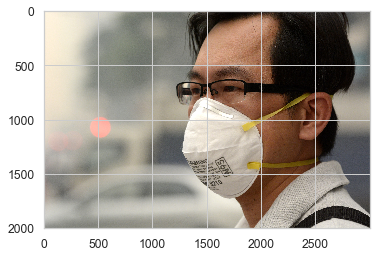

In [87]:
img = plt.imread(os.path.join(pictures,'0003.jpg'))
plt.imshow(img)
plt.show()

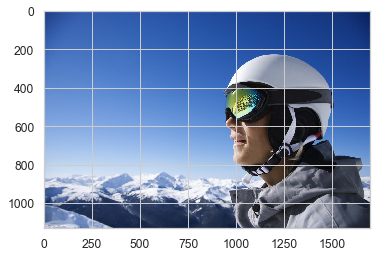

In [80]:
img = plt.imread(os.path.join(pictures,'1800.jpg'))
plt.imshow(img)
plt.show()

In [81]:
"""img_dir = "images/"
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
data = []
for f1 in files:
    img = cv2.imread(f1)
    data.append(img)
    """

'img_dir = "images/"\ndata_path = os.path.join(img_dir,\'*g\')\nfiles = glob.glob(data_path)\ndata = []\nfor f1 in files:\n    img = cv2.imread(f1)\n    data.append(img)\n    '

In [82]:
"""
print(type(data))
print(len(data))
print(data[0].shape)
data
"""

'\nprint(type(data))\nprint(len(data))\nprint(data[0].shape)\ndata\n'